# Auto Encoder
<p class="summary"> This tutorial introduces the auto encoder technique.</p> 
Auto encoders can be useful for feature extraction and pretraining deep neural networks.

The following two auto encoder flavors will be introduced: 

- Vanilla auto encoder
- Denoising auto encoder

Also. we'll pre-train a neural network using both methods and compare their classification results.

The auto encoder is an unsupervised feature learning algorithm. There is one output layer for each output layer, with hidden layers in between. Having the algorithm produce the same data which it was given, allows it to learn to reconstruct the data.

In general, the hidden layers' unit size will be smaller than that of the input layer. This structure causes the auto encoder to compress the information within the hidden layers. 

Once the training is complete, the hidden layer weights may be used as pretrained weights for other neural networks.

The compressed data may also be used by other machine learning algorithms.

![](ae01.png)


## Requirements

In this tutorial, following modules are required.

- Numpy 1.12.1
- Matplotlib 2.0.2
- Scikit-learn 0.18.2

In [1]:
import numpy as np
np.seterr(all="ignore")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

import renom as rm
from renom.optimizer import Adam
from renom.utility.initializer import Gaussian

## Load Data

We'll use the MNIST dataset to demonstrate how to use the auto enconder. You can use the download method provided in sklearn, acquire the data yourself from the following website:

● THE MNIST DATABASE  
http://yann.lecun.com/exdb/mnist/

After downloading the data, we need to split it into training and test sets.

In [2]:
# 'data_path' must point to the directory containing the data folder.
data_path = "../dataset"
mnist = fetch_mldata('MNIST original', data_home=data_path)

X = mnist.data
y = mnist.target

# Binarize ("one-hot") the image data.
X = X.astype(np.float32)
y = y.astype(np.float32)
X = np.array(X > 128, dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

binarizer = LabelBinarizer()
label_train = binarizer.fit_transform(y_train)
label_test = binarizer.transform(y_test)

# Training data size.
N = len(x_train)

## Vanilla Auto Encoder

For the first example, we'll build a vanilla auto encoder model using a sequential model.
Remember, the main principle of an auto encoder is that we have the same number of units in the input and output layers.

In this case, because the MNIST images are 28x28 pixels each, the auto encoder's input layer
and output sizes will both be 784(= 28x28).


### Model Definition

The model consists of 2 layers, both using the relu activation function.

We use the adam[1] gradient decent algorithm.

In [3]:
model_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(784),
    ])
optimizer = Adam()

### Train Loop

The training loop is defined below. The loss function in this example is the cross entropy between the raw digit data and the reconstructed image.

After the training loop finishes, we'll display the raw digit data along with the reconstructed image.
At least by eye, we can confirm that the reconstructed image has same shape as raw image.

epoch 00 train_loss:51.009064
epoch 02 train_loss:21.207394
epoch 04 train_loss:14.829244
epoch 06 train_loss:12.308509
epoch 08 train_loss:11.139716


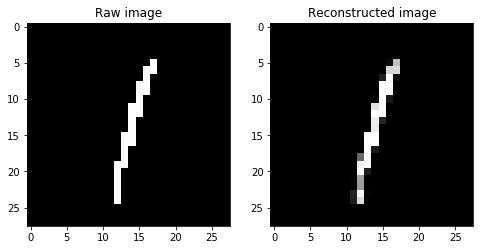

In [4]:
batch = 64
epoch = 10

for i in range(epoch):
    for j in range(N//batch):
        train_batch=x_train[j*batch:(j+1)*batch]
        with model_ae.train():
            z = model_ae(train_batch)
            loss = rm.sigmoid_cross_entropy(z, train_batch)
        loss.grad().update(optimizer)
    if i%2 == 0:print("epoch %02d train_loss:%f"%(i, loss))

# Show raw img and reconstructed img.
test_img = x_test[0]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img.reshape(28, 28), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].imshow(rm.sigmoid(model_ae(test_img)).reshape(28, 28), cmap="gray")
plt.show()

## Denoising auto encoder

The second flavor we'll demonstrate is the Denoising auto encoder[2], which is actually quite similar to the vanilla auto encoder. The only difference is that we provide noisy data as the input data.

Gaussian noise or salt and pepper noise are the generally used distributions.

In this case, we add salt and pepper noise. Specifically, we randomly set pixel values to 0 with a probability of 50%.

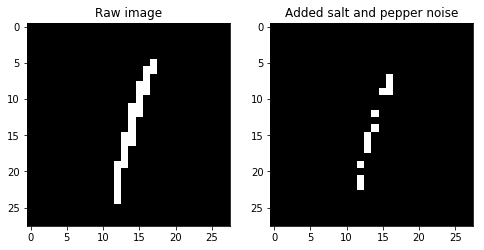

In [5]:
test_img = x_test[0].reshape(28, 28)
sp_noise = np.array(np.random.rand(*test_img.shape) > 0.5, dtype=np.bool)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img, cmap="gray")
ax[1].set_title("Added salt and pepper noise")
ax[1].imshow(test_img*sp_noise, cmap="gray")
plt.show()

### Model definition

The model definition is exactly the same as with the vanilla auto encoder.

In [6]:
model_denoise_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(784),
    ])
optimizer = Adam()

### Train Data

The training loop as well is unchanged (except that we substitute in the noised data.)

epoch 00 train_loss:91.471199
epoch 02 train_loss:73.140144
epoch 04 train_loss:72.041679
epoch 06 train_loss:71.260941
epoch 08 train_loss:69.084564


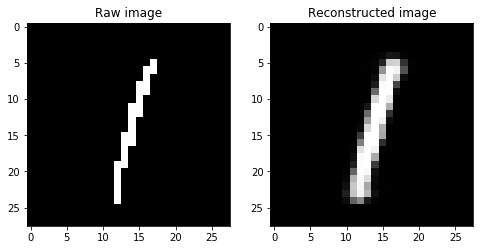

In [7]:
batch = 64
epoch = 10

for i in range(epoch):
    for j in range(N//batch):
        train_batch=x_train[j*batch:(j+1)*batch]
        with model_denoise_ae.train():
            sp_noise = np.array(np.random.rand(*train_batch.shape) > 0.5, dtype=np.bool)
            z = model_denoise_ae(train_batch*sp_noise)
            loss = rm.sigmoid_cross_entropy(z, train_batch)
        loss.grad().update(optimizer)
    if i%2 == 0:print("epoch %02d train_loss:%f"%(i, loss))

# Show raw img and reconstructed img.
test_img = x_test[0]
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
ax[0].set_title("Raw image")
ax[0].imshow(test_img.reshape(28, 28), cmap="gray")
ax[1].set_title("Reconstructed image")
ax[1].imshow(rm.sigmoid(model_denoise_ae(test_img)).reshape(28, 28), cmap="gray")
plt.show()

## Comparison of 2 pretrained model

In this section, we compare two pretrained models, using the two auto encoder flavors described above.

The input data here is the same noised data described above. We can confirm that the pretrained weights complement salt and pepper noise, leading to higher generalization performance.

We build a classification model below. These two models use the same hyper parameters, but different pretrained weights (coming from the two auto encoder examples above.)

In [8]:
pretrained_ae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(10),
    ])

pretrained_dae = rm.Sequential([
        rm.Dense(100),
        rm.Relu(),
        rm.Dense(10),
    ])

# Copy first weight parameters of first layer.
pretrained_ae[0].params = model_ae[0].params
pretrained_dae[0].params = model_denoise_ae[0].params

opt1 = Adam()
opt2 = Adam()

### Train loop

Now we can train the classification models.   

In [9]:
batch = 64
epoch = 40

train_loss1 = []
train_loss2 = []
validation_loss1 = []
validation_loss2 = []

for i in range(epoch):
    for j in range(N//batch):
        train_batch = x_train[j*batch:(j+1)*batch]
        response_batch = label_train[j*batch:(j+1)*batch].astype(np.float32)
        sp_noise = np.array(np.random.rand(*train_batch.shape) > 0.5)
        train_batch = train_batch*sp_noise

        with pretrained_ae.train():
            z = pretrained_ae(train_batch)
            loss1 = rm.softmax_cross_entropy(z, response_batch)
            
        with pretrained_dae.train():
            z = pretrained_dae(train_batch)
            loss2 = rm.softmax_cross_entropy(z, response_batch)
            
        loss1.grad().update(opt1)
        loss2.grad().update(opt2)
    
    validation1 = rm.softmax_cross_entropy(pretrained_ae(x_test), label_test)
    validation2 = rm.softmax_cross_entropy(pretrained_dae(x_test), label_test)
    
    train_loss1.append(loss1)
    train_loss2.append(loss2)
    validation_loss1.append(validation1)
    validation_loss2.append(validation2)
    
    strs = "epoch:%02d AE_loss:%f AE_validation:%f DAE_loss:%f DAE_validation:%f"
    if i%2 == 0:print(strs%(i, loss1, validation1, loss2, validation2))


epoch:00 AE_loss:0.561384 AE_validation:0.665277 DAE_loss:0.377859 DAE_validation:0.400579
epoch:02 AE_loss:0.330235 AE_validation:0.532445 DAE_loss:0.231801 DAE_validation:0.270267
epoch:04 AE_loss:0.377993 AE_validation:0.477424 DAE_loss:0.220577 DAE_validation:0.202235
epoch:06 AE_loss:0.284053 AE_validation:0.381976 DAE_loss:0.096848 DAE_validation:0.167779
epoch:08 AE_loss:0.256713 AE_validation:0.295453 DAE_loss:0.161372 DAE_validation:0.152546
epoch:10 AE_loss:0.186659 AE_validation:0.248264 DAE_loss:0.088071 DAE_validation:0.142935
epoch:12 AE_loss:0.280057 AE_validation:0.224904 DAE_loss:0.119961 DAE_validation:0.137183
epoch:14 AE_loss:0.178850 AE_validation:0.207520 DAE_loss:0.071178 DAE_validation:0.134815
epoch:16 AE_loss:0.141422 AE_validation:0.180905 DAE_loss:0.076573 DAE_validation:0.125874
epoch:18 AE_loss:0.116089 AE_validation:0.172424 DAE_loss:0.123805 DAE_validation:0.120988
epoch:20 AE_loss:0.109084 AE_validation:0.155472 DAE_loss:0.034230 DAE_validation:0.121413

## Learning Curve

Noe let's have a look at the two models' learning curves. The model pretrained with a denoising auto encoder appears to yield a lower validation error.

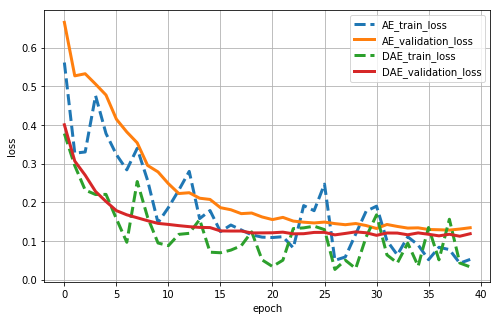

In [10]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.plot(train_loss1, label="AE_train_loss", linestyle="--", linewidth=3)
plt.plot(validation_loss1, label="AE_validation_loss", linewidth=3)
plt.plot(train_loss2, label="DAE_train_loss", linestyle="--", linewidth=3)
plt.plot(validation_loss2, label="DAE_validation_loss", linewidth=3)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [11]:
prediction1 = np.argmax(pretrained_ae(x_test).as_ndarray(), axis = 1)
prediction2 = np.argmax(pretrained_dae(x_test).as_ndarray(), axis = 1)

print("///////////// AE pretrained model //////////////")
print(classification_report(np.argmax(label_test, axis = 1), prediction1))

print("///////////// DAE pretrained model //////////////")
print(classification_report(np.argmax(label_test, axis = 1), prediction2))

///////////// AE pretrained model //////////////
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       685
          1       0.98      0.99      0.99       809
          2       0.97      0.96      0.97       723
          3       0.94      0.98      0.96       695
          4       0.99      0.97      0.98       660
          5       0.99      0.93      0.96       646
          6       0.97      0.99      0.98       688
          7       0.98      0.98      0.98       756
          8       0.97      0.97      0.97       668
          9       0.96      0.95      0.96       670

avg / total       0.97      0.97      0.97      7000

///////////// DAE pretrained model //////////////
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       685
          1       0.98      0.99      0.99       809
          2       0.97      0.98      0.97       723
          3       0.95      0.97      0.96       

### References

[1] Diederik P. Kingma, Jimmy Ba. Adam: A Method for Stochastic Optimization. 3rd International Conference for Learning Representations, San Diego, 2015.   
https://arxiv.org/abs/1412.6980


[2] Pascal Vincent, Hugo Larochelle, Yoshua Bengio and Pierre-Antoine Manzagol. Extracting and Composing Robust Features with Denoising Autoencoders. Proc. of ICML, 2008.  
http://www.iro.umontreal.ca/~vincentp/Publications/vincent_icml_2008.pdf